# Rolling Planning mit Lateness (Tardiness + Earliness)

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation


# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 15 # 15 min

In [3]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

## Generierung des Datensatzes für 20 Tage (Ankunft)

In [4]:
day_count = 20

In [5]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)

df_job_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)

df_job_times['Job'] = df_job_times['Job'].astype(str)
df_jssp['Job'] = df_jssp['Job'].astype(str)

df_job_times


Schedule-Informationen:
  Makespan: 30295


,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,2027.0
1,1,1,130,2683.0
2,2,2,151,2994.0
3,3,3,226,3505.0
4,4,4,386,2353.0
...,...,...,...,...
415,415,6,28598,30681.0
416,416,4,28606,30573.0
417,417,5,28722,31205.0
418,418,7,28746,31444.0


In [6]:
# Rundung für CP 
df_job_times["Arrival"] = np.floor(df_job_times["Arrival"]).astype(int)
df_job_times["Deadline"] = np.ceil(df_job_times["Deadline"]).astype(int)
df_job_times

,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,2027
1,1,1,130,2683
2,2,2,151,2994
3,3,3,226,3505
4,4,4,386,2353
...,...,...,...,...
415,415,6,28598,30681
416,416,4,28606,30573
417,417,5,28722,31205
418,418,7,28746,31444


In [7]:
# b) Bestimmung der "Ready Time"
df_job_times['Ready Time'] = ((df_job_times['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_jssp.groupby('Job')['Processing Time'].sum()
df_job_times = pd.merge(df_job_times, processing_time, on='Job')

# d) Bestimmung des Slacks
df_job_times['Slack'] = df_job_times['Deadline'] - (df_job_times['Ready Time'] + df_job_times['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_job_times['Slack'].min()

if min_slack < 0:
    df_job_times["Deadline"] = df_job_times["Deadline"] + abs(min_slack) + 150
df_job_times

# f) erneute Bestimmung des Slacks
df_job_times['Slack'] = df_job_times['Deadline'] - (df_job_times['Ready Time'] + df_job_times['Processing Time'])
df_job_times 

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,2027,1440,395,192
1,1,1,130,2683,1440,510,733
2,2,2,151,2994,1440,568,986
3,3,3,226,3505,1440,655,1410
4,4,4,386,2353,1440,393,520
...,...,...,...,...,...,...,...
415,415,6,28598,30681,28800,416,1465
416,416,4,28606,30573,28800,393,1380
417,417,5,28722,31205,28800,496,1909
418,418,7,28746,31444,28800,539,2105


In [8]:
df_job_times['Slack'].mean()

np.float64(1335.6571428571428)

In [9]:
file = file_template.format(text= "all_job_times")
df_job_times.to_csv(data_path / file, index = False)

file = file_template.format(text= "all_jssp")
df_jssp.to_csv(data_path / file, index = False)

### Params

In [10]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


> Tag 0 wird nicht ausgeführt

## Tag 1 (init. Tag - kein Rescheduling)

In [11]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [12]:
# aktuelle Produktionaufträge
df_jssp_curr, df_job_times_curr = process_filter.jobs_by_ready_time(df_job_times, df_jssp, ready_time = day_start)
df_job_times_curr

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,2027,1440,395,192
1,1,1,130,2683,1440,510,733
2,2,2,151,2994,1440,568,986
3,3,3,226,3505,1440,655,1410
4,4,4,386,2353,1440,393,520
5,5,5,464,2947,1440,496,1011
6,6,6,480,2563,1440,416,707
7,7,7,506,3204,1440,539,1225
8,8,8,526,3515,1440,597,1478
9,9,9,535,3238,1440,540,1258


### A) Scheduling

In [13]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(df_jssp_curr, df_job_times_curr, 
                                                                         schedule_start = day_start, w_t=5,
                                                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.13 Sekunden


,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,0,0,0,M00,49,2027,1440,29,1469,-558,0,558
1,4,4,0,M02,386,2353,1440,14,1454,-899,0,899
2,6,6,0,M01,480,2563,1440,46,1486,-1077,0,1077
3,5,5,0,M02,464,2947,1454,84,1538,-1409,0,1409
4,4,4,1,M00,386,2353,1469,6,1475,-878,0,878
...,...,...,...,...,...,...,...,...,...,...,...,...
195,16,1,9,M08,1254,3807,3777,30,3807,0,0,0
196,13,2,9,M04,1001,3844,3811,33,3844,0,0,0
197,18,5,9,M07,1397,3880,3855,25,3880,0,0,0
198,12,8,9,M08,950,3939,3865,74,3939,0,0,0


In [14]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              20
0 - 60          0
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


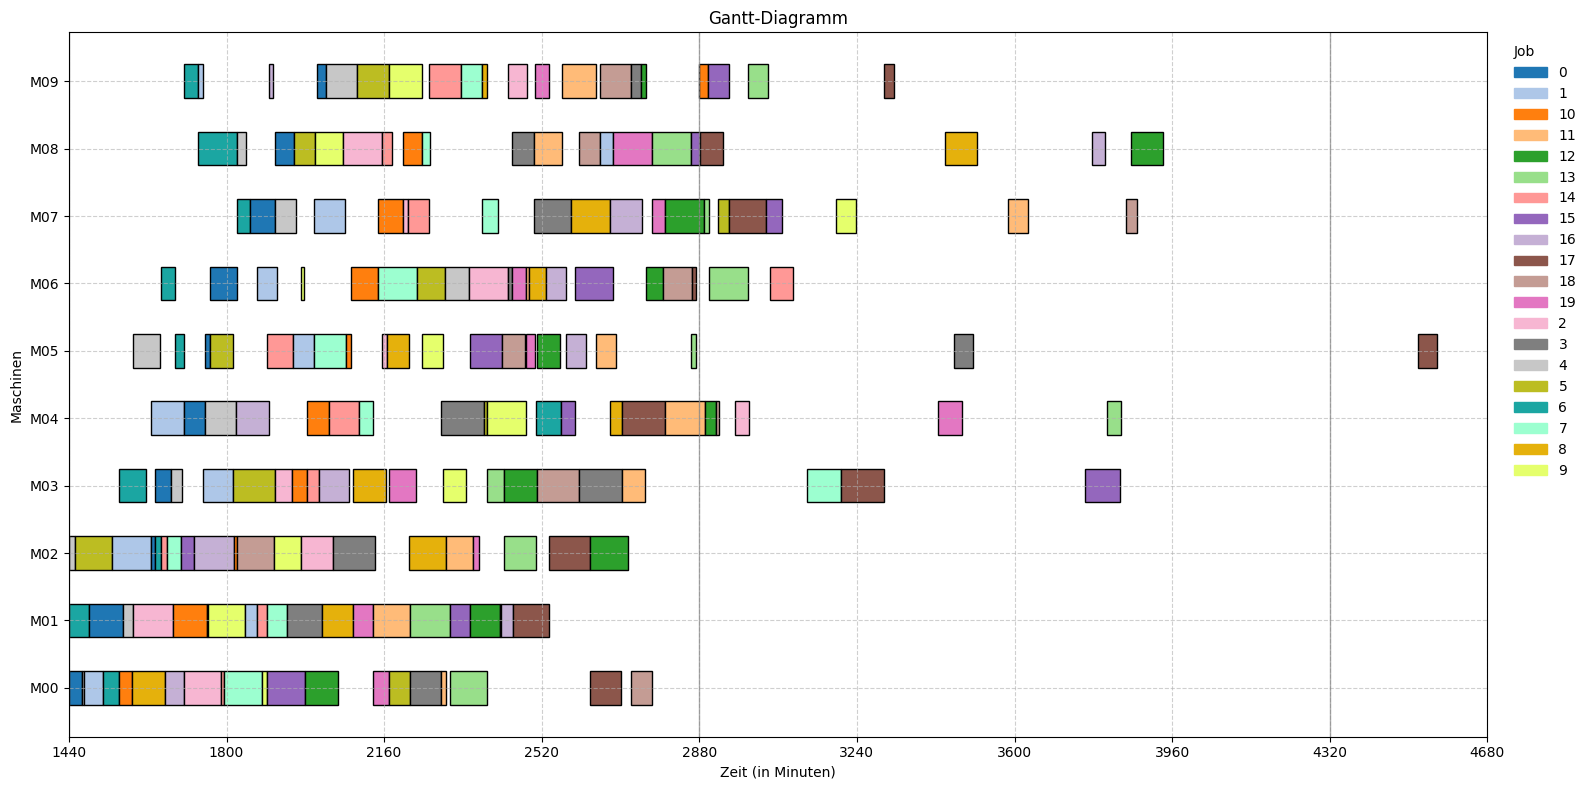

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [15]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [16]:
file = file_template.format(text= f"schedule_{day_numb:02d}_init")
file

'02_schedule_01_init.csv'

In [17]:
df_schedule.to_csv(data_path / file, index = False)

### C) Simulation

In [18]:
simulation = ProductionDaySimulation(df_schedule, vc=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job 0 started on M00
[24:00:00] Job 4 started on M02
[24:00:00] Job 6 started on M01
[24:11:07] Job 4 finished on M02 (after 11 minutes 07 seconds)
[24:14:00] Job 5 started on M02
[24:37:40] Job 0 finished on M00 (after 37 minutes 41 seconds)
[24:37:40] Job 4 started on M00
[24:43:19] Job 4 finished on M00 (after 05 minutes 39 seconds)
[24:43:19] Job 1 started on M00
[24:44:13] Job 6 finished on M01 (after 44 minutes 14 seconds)
[24:46:00] Job 0 started on M01
[25:11:45] Job 5 finished on M02 (after 57 minutes 46 seconds)
[25:25:47] Job 1 finished on M00 (after 42 minutes 28 seconds)
[25:25:47] Job 6 started on M00
[25:38:00] Job 1 started on M02
[26:06:39] Job 6 finished on M00 (after 40 minutes 52 seconds)
[26:06:39] Job 10 started on M00
[26:06:39] Job 6 started on M03
[26:19:13] Job 0 finished on M01 (after 93 minutes 14 seconds)
[26:19:13] Job 4 started on M01
[26:55:20] Job 4 finished on M01 (after 36 minutes 07 seconds)
[26:55:20] Job 2 started on M01
[26:55:20] Job 4

In [19]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,3,3,8,M09,226,3505,2725,22,2747,-758,0,758
1,18,5,7,M06,1397,3880,2798,65,2863,-1017,0,1017
2,11,9,8,M04,928,3631,2802,90,2892,-739,0,739
3,12,8,7,M07,950,3939,2802,89,2891,-1048,0,1048
4,13,2,5,M05,1001,3844,2862,10,2872,-972,0,972
...,...,...,...,...,...,...,...,...,...,...,...,...
29,16,1,9,M08,1254,3807,3777,30,3807,0,0,0
30,13,2,9,M04,1001,3844,3811,33,3844,0,0,0
31,18,5,9,M07,1397,3880,3855,25,3880,0,0,0
32,12,8,9,M08,950,3939,3865,74,3939,0,0,0


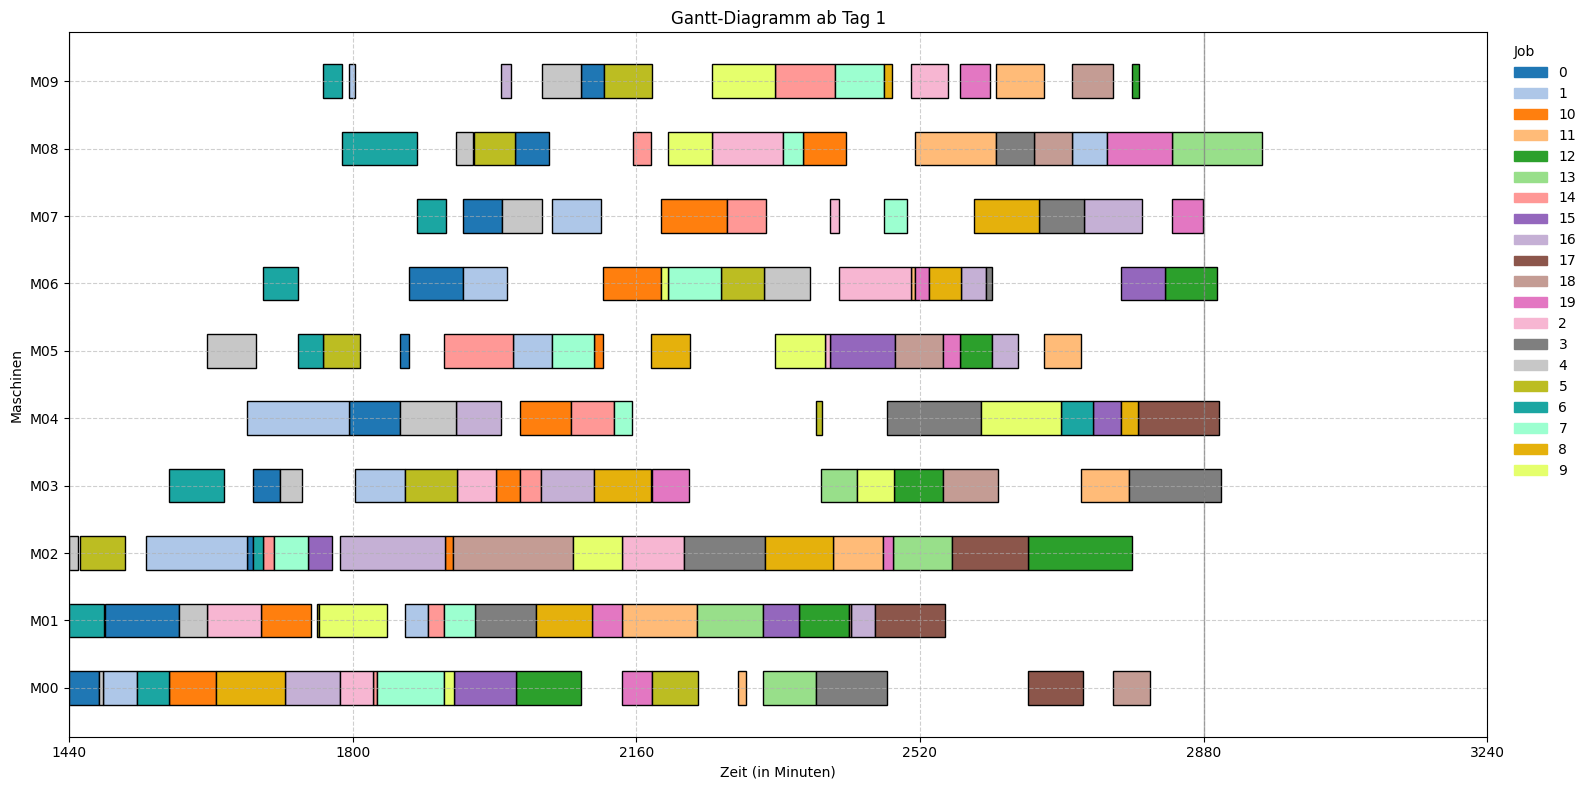

In [20]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

In [21]:
undone_numb = len(df_plan_undone)
print(f"Number of undone operations: {undone_numb}")

Number of undone operations: 34


In [22]:
file = file_template.format(text= f"execution_{day_numb:02d}")
file

'02_execution_01.csv'

In [23]:
df_execution.to_csv(data_path / file, index = False)

In [24]:
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
file

'02_plan_01_undone.csv'

In [25]:
df_plan_undone.to_csv(data_path / file, index = False)